In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from Bio import SeqIO

from datasets import (load_all_orfs,
                      load_GPCA_and_MAPPIT_data,
                      load_I3D_exp_20,
                      load_I3D_exp_24,
                      load_full_interactome_3d_2020,
                      load_lit_24,
                      load_AlphaFold_RoseTTAFold,
                      load_Y2H_union_25,
                      load_tarassov,
                      load_sys_nb,
                      load_protein_properties,
                      load_Michaelis_et_al_Nature_2023,
                      load_pdb_id_to_date,
                      load_afrf_yeast_search_space,
                      AFRF_YEAST_PUB_DATE,
                      YERI_DATE,
                      )
from plotting import (samogram_double,
                      validation_plot,
                      savefig, 
                      COLOR_Y2H, 
                      COLOR_ALPHAFOLD_ROSETTAFOLD, 
                      COLOR_I3D)
from alphafold_multimer_utils import read_alphafold_dimer_metrics

In [2]:
gene_properties = load_protein_properties()

df = read_alphafold_dimer_metrics('../data/alphafold/YeRI/')
df['orf_name_a'] = df['pair'].apply(lambda x: x.split('_')[0])
df['orf_name_b'] = df['pair'].apply(lambda x: x.split('_')[1])
orfs = load_all_orfs()
df['gene_name_a'] = df['orf_name_a'].map(orfs.set_index('orf_name')['gene_name'])
df['gene_name_b'] = df['orf_name_b'].map(orfs.set_index('orf_name')['gene_name'])
df['gene_name_a'] = df['gene_name_a'].fillna(df['orf_name_a'])
df['gene_name_b'] = df['gene_name_b'].fillna(df['orf_name_b'])
df['is_homodimer'] = (df['orf_name_a'] == df['orf_name_b'])
df = df.loc[~df['is_homodimer'], :].drop(columns=['is_homodimer'])  # 

val = load_GPCA_and_MAPPIT_data(remove_homodimers=False)
df['in_MAPPIT'] = df['pair'].isin(val.loc[(val['assay'] == 'MAPPIT')
                                          & (val['result_at_0_RRS'] == True), 'pair'].values)
df['in_GPCA'] = df['pair'].isin(val.loc[(val['assay'] == 'GPCA')
                                          & (val['result_at_0_RRS'] == True), 'pair'].values)

i3d = load_I3D_exp_24(remove_homodimers=False)
full_i3d = load_full_interactome_3d_2020(remove_homodimers=True)
afrf_full = load_AlphaFold_RoseTTAFold(remove_homodimers=True, restrict_to_high_confidence=False)
afrf_core = load_AlphaFold_RoseTTAFold(restrict_to_high_confidence=True)
lit = load_lit_24(remove_homodimers=False)
litbm = lit.loc[lit['category'] == 'Lit-BM', :].copy()
litbs = lit.loc[lit['category'] == 'Lit-BS', :].copy()
litnb = lit.loc[lit['category'] == 'Lit-NB', :].copy()
tarassov = load_tarassov(remove_homodimers=False)
sysnb = load_sys_nb(remove_homodimers=False)
apms = load_Michaelis_et_al_Nature_2023(remove_homodimers=True)
abbi = load_Y2H_union_25(remove_homodimers=True)
yeri = abbi.loc[abbi['YeRI'], :].copy()
y2h_union = abbi.loc[abbi['Uetz-screen'] & abbi['Ito-core'] & abbi['CCSB-YI1'] , :].copy()

for other_dataset, name in [(i3d, 'I3D-exp-24'),
                (afrf_full, 'AlphaFoldRoseTTAFold'),
                 (litbm, 'Lit-BM-24'),
                 (y2h_union, 'Y2H-union'),
                 (litbs, 'Lit-BS-24'),
                 (litnb, 'Lit-CC-24'),
                 (sysnb, 'AP/MS-06'),
                 (apms, 'AP/MS-23'),
                 (tarassov, 'Tarassov'),
                 ]:
    df['in_' + name] = df['pair'].isin(other_dataset.index)
df['has_interolog_structure'] = df['pair'].isin(full_i3d.loc[full_i3d['TYPE'] != 'Structure'].index)

df['in_AYC_pre_YeRI'] = (df['in_Lit-BM-24'] | 
                  df['in_Y2H-union'] | 
                  df['in_AlphaFoldRoseTTAFold'] |
                  df['in_I3D-exp-24'])
df['not_in_AYC_pre_YeRI'] = ~df['in_AYC_pre_YeRI']
df['novel'] = ~(df['in_AYC_pre_YeRI']
                | df['in_AP/MS-06']
                | df['in_AP/MS-23']
                | df['in_Lit-BS-24']
                | df['in_Lit-CC-24']
                | df['in_Tarassov']
                )

df['novel_hq'] = ~(df['in_AYC_pre_YeRI']
                | df['in_AP/MS-06']
                | df['has_interolog_structure']
                )

df['no_structure'] = ~(df['in_I3D-exp-24'] | df['in_AlphaFoldRoseTTAFold'] | df['has_interolog_structure'])
df['CCC_gte_5'] = df['n_contacts_PAE_lt_4A'] >= 5


print((df['no_structure'] & df['CCC_gte_5']).sum(),
      'confident YeRI predicted PPI structures with no previous structural model')

print(f'{df.shape[0]} predicted structures so far (of {yeri.shape[0]})')
print((df.loc[:, 'n_contacts_PAE_lt_4A'] > 5).sum(), '> 0.9')
print()
print(df['no_structure'].sum(), 'no previous experimental or predicted structure, of which:')
print((df.loc[df['no_structure'], 'n_contacts_PAE_lt_4A'] >= 5).sum(), 'confident')
print()
print(df['not_in_AYC_pre_YeRI'].sum(), 'not in high-quality binary PPI datasets, of which:')
print((df.loc[df['not_in_AYC_pre_YeRI'], 'n_contacts_PAE_lt_4A'] >= 5).sum(), 'confident')
print()
print(df['novel'].sum(), 'not in any previous experimenal PPI/PPA dataset, of which:')
print((df.loc[df['novel'], 'n_contacts_PAE_lt_4A'] >= 5).sum(), 'confident')
print()
print(df['novel_hq'].sum(), 'not in any previous high-quality binary PPI dataset or Sys-NB-06, of which:')
print((df.loc[df['novel_hq'], 'n_contacts_PAE_lt_4A'] >= 5).sum(), 'confident')

all_models = pd.read_csv(
    "../data/external/interactome3d_2020-05_scer_interactions_complete.dat",
    sep="\t",
)
pdb_to_date = load_pdb_id_to_date(set(all_models['PDB_ID'].unique()))
all_models["date"] = pd.to_datetime(all_models["PDB_ID"].map(pdb_to_date), errors="coerce")
full_i3d = pd.merge(
    full_i3d,
    all_models.groupby(["PROT1", "PROT2"])["date"].min().reset_index(),
    how="left",
    left_on=["uniprot_ac_1", "uniprot_ac_2"],
    right_on=["PROT1", "PROT2"],
)
full_i3d['pair'] = full_i3d['orf_name_a'] + '_' + full_i3d['orf_name_b']
full_i3d = full_i3d.set_index('pair')

# using the older I3D-20 since AF/RF yeast came out in 21 
i3d20 = load_I3D_exp_20(remove_homodimers=True)
afrf_core['gene_name_a'] = afrf_core['orf_name_a'].map(orfs.set_index('orf_name')['gene_name'])
afrf_core['gene_name_b'] = afrf_core['orf_name_b'].map(orfs.set_index('orf_name')['gene_name'])
afrf_core['gene_name_a'] = afrf_core['gene_name_a'].fillna(afrf_core['orf_name_a'])
afrf_core['gene_name_b'] = afrf_core['gene_name_b'].fillna(afrf_core['orf_name_b'])
afrf_core['has_interolog_structure'] = (afrf_full['PDB_complex'] != 'na')
afrf_core['in_I3D-exp-20'] = afrf_core.index.isin(i3d20.index)

# get novel structure PPIs (not in full-I3D)
ns_yeri = df.loc[(df['n_contacts_PAE_lt_4A'] >= 5) & 
                 ~df['in_I3D-exp-24'] & 
                 ~df['has_interolog_structure'] & 
                 ~df['in_AlphaFoldRoseTTAFold'], :]
ns_afrf = afrf_core.loc[~afrf_core['in_I3D-exp-20'] & 
                        ~afrf_core['has_interolog_structure']]

df['date'] = pd.to_datetime(YERI_DATE)
afrf_core['date'] = pd.to_datetime(AFRF_YEAST_PUB_DATE)

sin = pd.concat([
    full_i3d.loc[full_i3d['orf_name_a'] != full_i3d['orf_name_b']].reset_index().copy(),
    afrf_core.loc[(afrf_core['PDB_complex'] == 'na'), :].reset_index().copy(),
    df.loc[df['n_contacts_PAE_lt_4A'] > 5, :].copy()
                ])
sin = sin.sort_values('date').drop_duplicates(subset=['pair']).set_index('pair')
sin['category'] = np.nan
sin.loc[sin['TYPE'] == 'Structure', "category"] = 'Experimental structure'
sin.loc[sin['TYPE'].isin(['Model', 'Dom_dom_model']), "category"] = 'Homology model'
sin.loc[sin['TYPE'].isnull() & sin['PPI Score'].notnull(), "category"] = 'AF/RF'
sin.loc[sin['TYPE'].isnull() & sin['PPI Score'].isnull() & sin['in_AYC_pre_YeRI'].notnull(), "category"] = 'YeRI+AF'
if sin['category'].isnull().any():
    raise UserWarning('unexpected mising values')

NOTE: dropping 6 pairs with missing ORF names
NOTE: dropping 6 pairs with missing ORF names
237 confident YeRI predicted PPI structures with no previous structural model
1870 predicted structures so far (of 1880)
441 > 0.9

1637 no previous experimental or predicted structure, of which:
237 confident

1577 not in high-quality binary PPI datasets, of which:
211 confident

1432 not in any previous experimenal PPI/PPA dataset, of which:
153 confident

1540 not in any previous high-quality binary PPI dataset or Sys-NB-06, of which:
186 confident


In [3]:
aa_seqs = {s.description.split()[0]: str(s.seq)[:-1] for s in SeqIO.parse('../data/external/orf_trans_all.fasta', 'fasta')}
prot_length = {k: len(v) for k, v in aa_seqs.items()}
# of the 237 how many are below the length cutoff?
df['orf_length_a'] = df['orf_name_a'].map(prot_length)
df['orf_length_b'] = df['orf_name_b'].map(prot_length)
print(
    df.loc[df['no_structure'] & df['CCC_gte_5'], 'orf_length_a'].max(),
    df.loc[df['no_structure'] & df['CCC_gte_5'], 'orf_length_b'].max()
      )

917 965


In [4]:
df['pair'].isin(set(afrf_full.index).difference(set(afrf_core.index))).sum()

17

In [5]:
df.loc[df['pair'].isin(
    set(afrf_full.index).difference(set(afrf_core.index)))
]

,pair,gene_name_a,gene_name_b,contact_probability,pDockQ,PPV_from_pDockQ,iPTM+PTM,iPAE,n_contacts_PAE_lt_4A,orf_name_a,orf_name_b,in_MAPPIT,in_GPCA,in_I3D-exp-24,in_AlphaFoldRoseTTAFold,in_Lit-BM-24,in_Y2H-union,in_Lit-BS-24,in_Lit-CC-24,in_AP/MS-06,in_AP/MS-23,in_Tarassov,has_interolog_structure,in_AYC_pre_YeRI,not_in_AYC_pre_YeRI,novel,novel_hq,no_structure,CCC_gte_5,date,orf_length_a,orf_length_b
73,YDL147W_YDR179C,RPN5,CSN9,0.998452,0.280,0.802235,0.849152,2.977181,40,YDL147W,YDR179C,False,False,False,True,True,False,False,False,True,True,False,False,True,False,False,False,False,True,2025-07-09,445,162
165,YBL078C_YNL223W,ATG8,ATG4,0.999624,0.659,0.981280,0.892091,3.926955,120,YBL078C,YNL223W,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,2025-07-09,117,494
348,YER136W_YFL038C,GDI1,YPT1,0.949807,0.239,0.777661,0.706969,8.080850,20,YER136W,YFL038C,False,True,True,True,True,False,False,False,True,True,True,False,True,False,False,False,False,True,2025-07-09,451,206
415,YDR279W_YLR154C,RNH202,RNH203,0.999789,0.694,0.981280,0.856524,3.691023,188,YDR279W,YLR154C,True,True,False,True,False,False,False,True,True,True,False,False,True,False,False,False,False,True,2025-07-09,350,110
464,YML031W_YMR153W,NDC1,NUP53,0.983430,0.196,0.740063,0.578102,18.117062,55,YML031W,YMR153W,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,True,2025-07-09,655,475
601,YGR129W_YMR213W,SYF2,CEF1,0.931818,0.135,0.706157,0.435764,21.704262,16,YGR129W,YMR213W,False,False,True,True,True,False,False,False,False,True,False,False,True,False,False,False,False,True,2025-07-09,215,590
735,YER074W-A_YNL024C-A,YOS1,KSH1,0.999189,0.319,0.822382,0.610627,4.516063,39,YER074W-A,YNL024C-A,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,2025-07-09,85,72
804,YCR086W_YDR439W,CSM1,LRS4,0.997199,0.563,0.916299,0.596300,15.266401,59,YCR086W,YDR439W,False,False,True,True,True,True,False,False,True,False,False,False,True,False,False,False,False,True,2025-07-09,190,347
818,YER136W_YOR089C,GDI1,VPS21,0.870776,0.184,0.740063,0.622507,12.498369,1,YER136W,YOR089C,False,True,False,True,True,False,False,False,True,True,True,True,True,False,False,False,False,False,2025-07-09,451,210
906,YGR146C_YML051W,ECL1,GAL80,0.746124,0.150,0.713918,0.348239,25.446873,0,YGR146C,YML051W,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,2025-07-09,211,435


In [6]:
afrf_space = load_afrf_yeast_search_space()

(df.loc[df['no_structure'] & (df['n_contacts_PAE_lt_4A'] >= 5),
       'pair'].isin(afrf_space.index)
).value_counts()

False    171
True      66
Name: pair, dtype: int64

286


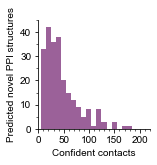

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=2)
ncc = df.loc[df['no_structure'] & (df['n_contacts_PAE_lt_4A'] >= 5), 
        'n_contacts_PAE_lt_4A'].values
print(ncc.max())
ax.hist(ncc, range=(4.5, 224.5), bins=22, color=COLOR_Y2H)
ax.set_xlabel('Confident contacts')
ax.set_ylabel('Predicted novel PPI structures')
ax.set_xticks(range(0, 221, 50), minor=False)
ax.set_xticks(range(0, 221, 10), minor=True)
ax.set_yticks(range(0, 45, 10), minor=False)
ax.set_yticks(range(0, 46, 5), minor=True)
ax.set_xlim(0, 220)
for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)
fig.savefig('../figures/YeRI-novel-AF-predictions_confident-contacts_hist.pdf', bbox_inches='tight')

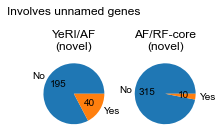

In [8]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=3, h=1.5)
(
    (
    (ns_yeri['gene_name_a'] == ns_yeri['orf_name_a'])
     | (ns_yeri['gene_name_b'] == ns_yeri['orf_name_b'])).value_counts()
.plot.pie(labels=['No', 'Yes'], ylabel='', ax=axs[0], autopct=lambda x: int(x * ns_yeri.shape[0] / 100))
)

(
    (
    (ns_afrf['gene_name_a'] == ns_afrf['orf_name_a'])
     | (ns_afrf['gene_name_b'] == ns_afrf['orf_name_b'])).value_counts()
.plot.pie(labels=['No', 'Yes'], ylabel='', ax=axs[1], autopct=lambda x: int(x * ns_afrf.shape[0] / 100))
)

axs[0].set_title('Involves unnamed genes\n\nYeRI/AF\n(novel)')
axs[1].set_title('AF/RF-core\n(novel)')
fig.savefig('../figures/YeRI-structurally-novel-AF-predictions-vs-AFRF-novel_unnamed-genes_pie.pdf', bbox_inches='tight')

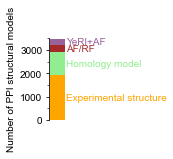

In [9]:
cats = ['Experimental structure',
        'Homology model',
        'AF/RF',
        'YeRI+AF']
colors = [COLOR_I3D, 'lightgreen', COLOR_ALPHAFOLD_ROSETTAFOLD, COLOR_Y2H]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=0.3, h=1.5)

for i in range(len(cats)):
        height = (sin['category'] == cats[i]).sum()
        bottom = sin['category'].isin(cats[:i]).sum()
        ax.bar(x=0, height=height, bottom=bottom, color=colors[i])
        ax.text(x=ax.get_xlim()[1],
                y=bottom + height / 2, 
                s=cats[i], 
                va='center', 
                ha='left', 
                color=colors[i],
                )



ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0., 3500)
ax.set_yticks(range(0, 3501, 1000))
ax.set_yticks(range(0, 3501, 500), minor=True)
ax.set_xticks([])
ax.set_ylabel('Number of PPI structural models')

savefig('structural-models_stacked-bar')

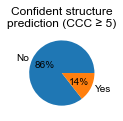

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=1.5)
(
    (df.loc[df['no_structure'], 'n_contacts_PAE_lt_4A'] >= 5)
.value_counts().plot.pie(
    labels=['No', 'Yes'], 
    ylabel='', 
    ax=ax, 
    autopct=lambda x: '{:.0f}%'.format(x)
    )
)
ax.set_title('Confident structure\nprediction (CCC ≥ 5)')
fig.savefig('../figures/YeRI-no-structure-AF-success-rate_pie.pdf',
            bbox_inches='tight')

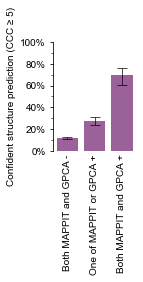

In [11]:
df['GPCA_MAPPIT_cat'] = np.nan
df.loc[(~df['in_MAPPIT'] & ~df['in_GPCA']),
       'GPCA_MAPPIT_cat'] = 'Both MAPPIT and GPCA -'
df.loc[(df['in_MAPPIT'] ^ df['in_GPCA']),
       'GPCA_MAPPIT_cat'] = 'One of MAPPIT or GPCA +'
df.loc[(df['in_MAPPIT'] & df['in_GPCA']),
       'GPCA_MAPPIT_cat'] = 'Both MAPPIT and GPCA +'


GPCA_MAPPIT_cats = ['Both MAPPIT and GPCA -',
                    'One of MAPPIT or GPCA +',
                    'Both MAPPIT and GPCA +']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=2)
validation_plot(data=df.loc[df['no_structure'], :],
                selections=[df['GPCA_MAPPIT_cat'] == c for c in GPCA_MAPPIT_cats],
                result_column='CCC_gte_5',
                labels=GPCA_MAPPIT_cats,
                xlabel_rotation=90,
                ax=ax,
                y_max=1,
                colors=[COLOR_Y2H] * 3,
                errorbar_capsize=0.5,
                errorbar_thickness=0.7,
                draw_numbers=False,
                )
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_facecolor('white')
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
ax.set_ylabel('Confident structure prediction (CCC ≥ 5)')
fig.savefig('../figures/YeRI-AF-success-rate-by-MAPPIT-GPCA_bar.pdf',
            bbox_inches='tight')

In [12]:
for cmap in [
    LinearSegmentedColormap.from_list('Y2H-union-25', ['white', COLOR_Y2H, 'black'], 1000),
    LinearSegmentedColormap.from_list('AF/RF', ['white', 'brown', 'black'], 1000),]:
    plt.register_cmap(name=cmap.name, cmap=cmap)

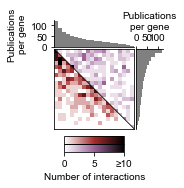

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=2, h=2)

samogram_double(
    ppis=(ns_yeri, ns_afrf),
    ax=ax,
    draw_up=True,
    draw_right=True,
    gene_property=gene_properties['Publication count'],
    n_bins=20,
    ylabel='Publications\nper gene',
    vmax=10,
    size_ratio=0.25,
    zticks=[0, 5, 10],
    yticks=[0, 50, 100],
    colorbar_width=0.75,
    cmaps=('Y2H-union-25', 'AF/RF'),
    correct_diagonal=True,
    self_interactions=False,
    color='grey',
    labels=('YeRI/AF (novel)', 'AF/RF-core (novel)'),
)

fig.savefig('../figures/YeRI-novel-structures-vs-AFRF-alphafold_samogram.pdf',
            bbox_inches='tight')